In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, confusion_matrix, classification_report
from glob import glob


In [2]:
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
import time
import datetime

###  Prétraitement des données (chargement des données)

1. Chargement des données 


In [3]:
df = pd.read_csv('Source/flipkart_com-ecommerce_sample_1050.csv',sep=',')

In [4]:
path_img = 'Source/Images'

In [5]:
# lire des caractère sur une image
import nltk
nltk.download('punkt')
tokenizer = nltk.RegexpTokenizer(r'\w+')
token = np.array(df.product_category_tree)

token = [tokenizer.tokenize(i.lower()) for i in token]

bigram = [list(nltk.bigrams(bigram)) for bigram in token]

token_bigram = pd.Series(bigram)

cat_name = np.array([token_bigram[i][0] for i in range(len(token_bigram))])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dragomir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
df_token = pd.DataFrame(cat_name, columns=['cat1','cat2'])
df_token = df_token.cat1 

In [7]:
df['category_name'] = df_token

In [8]:
from sklearn import preprocessing


# preprocessing encodage des données
encodage = preprocessing.LabelEncoder()
encodage.fit(df.category_name)
df["label"] = encodage.transform(df.category_name)
# data.head(5)
df.category_name.value_counts()

home         300
baby         150
watches      150
kitchen      150
beauty       150
computers    150
Name: category_name, dtype: int64

In [9]:
img = [img for img in df.image]
img_path = []

for i in range(len(img)):
    img_path.append(path_img+"/"+img[i])
    df['path_img'] = path_img+"/"+img[i]

In [10]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = EfficientNetV2M(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    # 6 sorties correepondant aux 6 classes 
    predictions = Dense(6, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model



In [11]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in data['path'] :
        img = (load_img(image_num,target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img =preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

In [16]:

dframe = {'path':img_path[:900],'label':df.label[:900].astype(str)}
dframe = pd.DataFrame(dframe)
dframe


dftest = {'path':img_path[901:1050],'label':df.label[901:1050].astype(str)}
dftest = pd.DataFrame(dftest)
dframe_test = dftest


#images_np = image_prep_fct(dframe)
#print(images_np.shape)

In [17]:

    
images_np = image_prep_fct(dframe)
print(images_np.shape)
images_np_test = image_prep_fct(dframe_test)
print(images_np_test.shape)

C:\Users\Dragomir\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(900, 224, 224, 3)
(149, 224, 224, 3)


In [18]:
images_np.shape

(900, 224, 224, 3)

In [19]:
X = images_np
y = to_categorical(dframe['label'])

X_test = images_np_test
y_test = to_categorical(dframe_test['label'])

y

array([[0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(675, 224, 224, 3)

In [23]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "Models/model1_best_w.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

In [24]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=15, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)



Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 0.8017 - accuracy: 0.7689
Epoch 1: val_loss improved from inf to 0.46035, saving model to Models\model1_best_w.h5
11/11 [==============================] - 111s 8s/step - loss: 0.8017 - accuracy: 0.7689 - val_loss: 0.4603 - val_accuracy: 0.8578
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 0.3197 - accuracy: 0.9215
Epoch 2: val_loss improved from 0.46035 to 0.40288, saving model to Models\model1_best_w.h5
11/11 [==============================] - 89s 8s/step - loss: 0.3197 - accuracy: 0.9215 - val_loss: 0.4029 - val_accuracy: 0.8756
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.9496
Epoch 3: val_loss improved from 0.40288 to 0.38326, saving model to Models\model1_best_w.h5
11/11 [==============================] - 89s 8s/step - loss: 0.2259 - accuracy: 0.9496 - val_loss: 0.3833 - val_accuracy: 0.8889
Epoch 4/15
11/11 [==============================] - ETA: 0

In [25]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

22/22 [==============================] - 64s 3s/step - loss: 0.0224 - accuracy: 0.9911
Training Accuracy: 0.9911

8/8 [==============================] - 23s 3s/step - loss: 0.4643 - accuracy: 0.8756
Validation Accuracy:  0.8756


In [26]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8889
Test Accuracy       :  0.7315


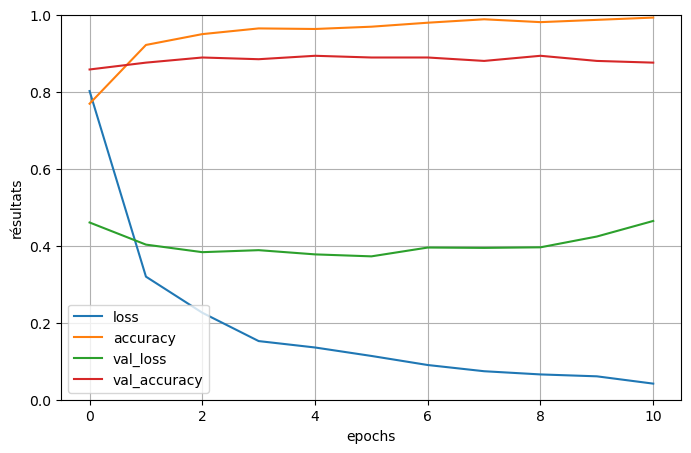

In [27]:
pd.DataFrame(history1.history).plot(figsize = (8,5))
plt.xlabel('epochs')
plt.ylabel('résultats')
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [28]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num[:10])
print()
print(y_val_pred[:10])

8/8 [==============================] - 31s 3s/step
[5 1 5 0 5 3 0 0 4 1]

[5 1 5 3 5 3 0 0 4 1]


In [29]:
conf_mat = confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

print(classification_report(y_val_num, y_val_pred))

[[21  1  1  5  0  0]
 [ 0 24  3  5  1  1]
 [ 0  0 34  0  0  0]
 [ 3  0  0 53  0  1]
 [ 0  2  1  1 31  0]
 [ 0  0  0  0  0 37]]
              precision    recall  f1-score   support

           0       0.88      0.75      0.81        28
           1       0.89      0.71      0.79        34
           2       0.87      1.00      0.93        34
           3       0.83      0.93      0.88        57
           4       0.97      0.89      0.93        35
           5       0.95      1.00      0.97        37

    accuracy                           0.89       225
   macro avg       0.90      0.88      0.88       225
weighted avg       0.89      0.89      0.89       225



In [33]:
y_test_num = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model1.predict(X_test), axis=1)
print(y_test_num)
print()
print(y_test_pred)

5/5 [==============================] - 15s 3s/step
[3 4 3 0 3 3 0 0 0 0 3 3 5 0 0 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 1 3 3
 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 1 4 0 0 3 0 0 0 3 3
 0 1 0 4 0 0 0 0 0 3 1 3 3 1 3 0 4 4 3 4 0 0 3 4 3 4 0 2 4 0 1 1 1 4 3 0 0
 3 1 0 2 1 3 2 2 3 2 3 2 2 2 3 3 2 3 1 1 2 3 2 2 2 3 1 3 0 0 0 0 0 0 0 0 0
 0]

[3 4 3 3 3 0 0 0 0 0 3 4 5 0 0 3 0 3 3 0 3 3 3 1 3 3 3 3 3 3 3 3 3 0 1 3 2
 3 3 3 3 3 1 3 3 1 3 1 3 3 3 3 0 3 1 1 3 3 3 3 3 3 3 3 1 1 3 3 3 3 3 0 3 3
 0 1 0 4 0 0 3 0 0 3 1 3 3 3 3 0 3 3 3 4 1 1 3 4 3 0 0 2 4 4 1 1 2 1 3 0 3
 3 1 0 2 1 3 2 2 3 2 3 2 2 2 3 3 2 3 0 1 2 3 2 2 2 3 0 3 3 3 3 3 3 3 3 3 3
 3]


In [34]:
conf_mat = confusion_matrix(y_test_num, y_test_pred)
print(conf_mat)

print(classification_report(y_test_num, y_test_pred))

[[17  2  0 17  1  0]
 [ 2 11  1  1  0  0]
 [ 0  0 13  0  0  0]
 [ 5  3  1 62  1  0]
 [ 1  3  0  2  5  0]
 [ 0  0  0  0  0  1]]
              precision    recall  f1-score   support

           0       0.68      0.46      0.55        37
           1       0.58      0.73      0.65        15
           2       0.87      1.00      0.93        13
           3       0.76      0.86      0.81        72
           4       0.71      0.45      0.56        11
           5       1.00      1.00      1.00         1

    accuracy                           0.73       149
   macro avg       0.77      0.75      0.75       149
weighted avg       0.73      0.73      0.72       149



In [35]:
list_labels = df.category_name.unique()
list_labels
nb_classe = np.arange(0,6)
nb_classe

array([0, 1, 2, 3, 4, 5])

<AxesSubplot:>

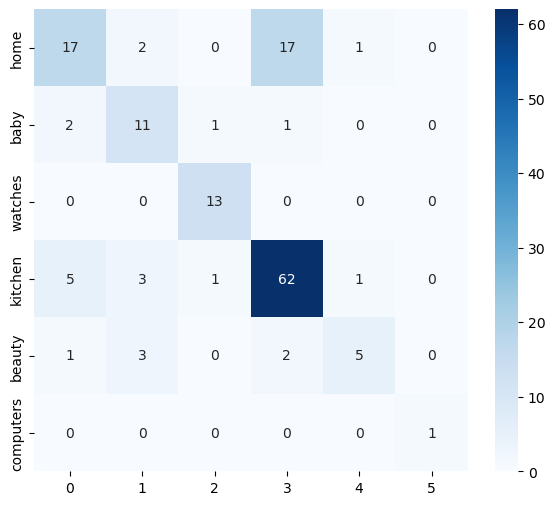

In [38]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in nb_classe])
plt.figure(figsize = (7,6))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Data augmentation 

In [423]:

dframe = {'path':img_path[:900],'label':df.label[:900].astype(str)}
dframe = pd.DataFrame(dframe)
dframe


dftest = {'path':img_path[901:1050],'label':df.label[901:1050].astype(str)}
dftest = pd.DataFrame(dftest)
dframe_test = dftest


#images_np = image_prep_fct(dframe)
#print(images_np.shape)

In [424]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='path', y_col='label',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [425]:
datagen_train = ImageDataGenerator(

    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(dframe, datagen_train, data_type='training')
val_flow = data_flow_fct(dframe, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(validation_split=0,preprocessing_function=preprocess_input)
test_flow = data_flow_fct(dframe_test, datagen_test, data_type=None)


Found 675 validated image filenames belonging to 6 classes.
Found 225 validated image filenames belonging to 6 classes.
Found 149 validated image filenames belonging to 6 classes.


In [426]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_data__augmented_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_16 (Rescaling)       (None, 224, 224, 3)  0           ['input_13[0][0]']               
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling_16[0][0]']           
                                )                                                                 
                                                                                            

In [427]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [428]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=3, callbacks=callbacks_list, verbose=1)


Epoch 1/3
14/22 [==================>...........] - ETA: 32s - loss: 0.8597 - accuracy: 0.7143

C:\Users\Dragomir\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


22/22 [==============================] - ETA: 0s - loss: 0.7213 - accuracy: 0.7704
Epoch 1: val_loss improved from inf to 0.76150, saving model to .\model2_data__augmented_weights.h5
22/22 [==============================] - 150s 6s/step - loss: 0.7213 - accuracy: 0.7704 - val_loss: 0.7615 - val_accuracy: 0.8044
Epoch 2/3
22/22 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.9037
Epoch 2: val_loss improved from 0.76150 to 0.51400, saving model to .\model2_data__augmented_weights.h5
22/22 [==============================] - 123s 6s/step - loss: 0.2976 - accuracy: 0.9037 - val_loss: 0.5140 - val_accuracy: 0.8533
Epoch 3/3
22/22 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.9333
Epoch 3: val_loss improved from 0.51400 to 0.44086, saving model to .\model2_data__augmented_weights.h5
22/22 [==============================] - 123s 6s/step - loss: 0.2331 - accuracy: 0.9333 - val_loss: 0.4409 - val_accuracy: 0.8711


In [429]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

22/22 [==============================] - 87s 4s/step - loss: 0.1180 - accuracy: 0.9748
Training Accuracy   : 0.9748

8/8 [==============================] - 30s 3s/step - loss: 0.4890 - accuracy: 0.8667
Validation Accuracy :  0.8667


In [430]:
# chargement de la meilleur configuration
# Score de l'epoch optimal


model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8711
Test Accuracy       :  0.7517


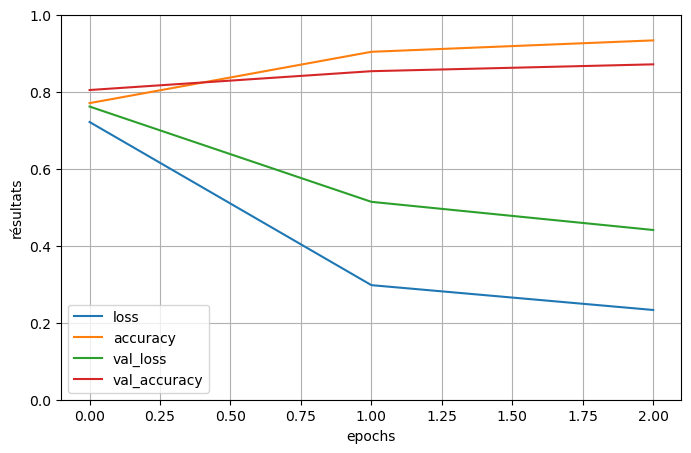

In [431]:
pd.DataFrame(history2.history).plot(figsize = (8,5))
plt.xlabel('epochs')
plt.ylabel('résultats')
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [407]:
test_flow[0][0][0].shape

(256, 256, 3)

In [409]:
images_np_test[0].shape

(224, 224, 3)

In [432]:
val_flow.labels[:5]

[3, 0, 0, 3, 3]

In [441]:
y_val_num = train_flow.labels
y_val_pred = np.argmax(model2.predict(train_flow), axis=1)
print(y_val_num[:10])
print()
print(y_val_pred[:10])

16/22 [====================>.........] - ETA: 23s

C:\Users\Dragomir\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


22/22 [==============================] - 85s 4s/step
[3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 3, 4, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 4, 4, 0, 5, 5, 5, 5, 5, 3, 0, 5, 3, 5, 5, 3, 0, 3, 3, 0, 0, 0, 0, 4, 2, 0, 4, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 2, 4, 2, 2, 2, 2, 2, 3, 1, 0, 3, 0, 1, 0, 3, 3, 2, 2, 2, 0, 0, 0, 3, 4, 3, 4, 4, 3, 3, 2, 1, 0, 4, 3, 1, 0, 0, 0, 0, 0, 4, 1, 4, 4, 1, 4, 1, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 2, 2, 2, 5, 5, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

In [442]:
conf_mat = confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

print(classification_report(y_val_num, y_val_pred))

[[10  7 19 34  7 16]
 [14 21 16 27 12 26]
 [15 25 35 28  7 18]
 [27 32 32 31 14 29]
 [ 6 10 10 12  5  9]
 [15 18 18 38  7 25]]
              precision    recall  f1-score   support

           0       0.11      0.11      0.11        93
           1       0.19      0.18      0.18       116
           2       0.27      0.27      0.27       128
           3       0.18      0.19      0.19       165
           4       0.10      0.10      0.10        52
           5       0.20      0.21      0.20       121

    accuracy                           0.19       675
   macro avg       0.18      0.18      0.18       675
weighted avg       0.19      0.19      0.19       675



In [439]:
y_val_num = test_flow.labels
y_val_pred = np.argmax(model2.predict(test_flow), axis=1)
print(y_val_num[:10])
print()
print(y_val_pred[:10])

5/5 [==============================] - 19s 4s/step
[3, 4, 3, 0, 3, 3, 0, 0, 0, 0, 3, 3, 5, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 1, 4, 0, 0, 3, 0, 0, 0, 3, 3, 0, 1, 0, 4, 0, 0, 0, 0, 0, 3, 1, 3, 3, 1, 3, 0, 4, 4, 3, 4, 0, 0, 3, 4, 3, 4, 0, 2, 4, 0, 1, 1, 1, 4, 3, 0, 0, 3, 1, 0, 2, 1, 3, 2, 2, 3, 2, 3, 2, 2, 2, 3, 3, 2, 3, 1, 1, 2, 3, 2, 2, 2, 3, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[3 0 3 3 2 1 3 4 3 2 4 3 4 0 3 0 0 3 3 3 3 3 3 3 3 3 2 3 2 0 0 0 3 0 3 0 3
 3 0 3 3 0 3 3 3 3 3 4 0 0 4 2 2 3 1 4 1 3 2 3 1 1 1 1 3 3 3 1 3 2 3 3 1 0
 1 3 3 3 1 2 3 3 3 3 0 3 3 3 3 0 3 3 1 3 3 3 3 5 1 3 2 1 3 3 3 1 3 0 3 0 1
 3 3 3 3 3 3 3 3 3 0 4 3 3 3 0 3 0 3 0 3 3 2 2 3 2 2 3 3 4 1 0 0 3 0 2 0 3
 4]


In [440]:
conf_mat = confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

print(classification_report(y_val_num, y_val_pred))

[[ 7  5  5 17  3  0]
 [ 2  1  0 12  0  0]
 [ 2  1  2  8  0  0]
 [13 10  8 37  4  0]
 [ 2  0  0  7  1  1]
 [ 0  0  0  0  1  0]]
              precision    recall  f1-score   support

           0       0.27      0.19      0.22        37
           1       0.06      0.07      0.06        15
           2       0.13      0.15      0.14        13
           3       0.46      0.51      0.48        72
           4       0.11      0.09      0.10        11
           5       0.00      0.00      0.00         1

    accuracy                           0.32       149
   macro avg       0.17      0.17      0.17       149
weighted avg       0.31      0.32      0.32       149



In [415]:
image = load_img(img_path[2], target_size=(224, 224))
image = img_to_array(image) 
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)
pred = model2.predict(image)
pred

1/1 [==============================] - 0s 222ms/step


array([[1.4685185e-02, 5.4729859e-05, 1.2578111e-05, 9.8522216e-01,
        8.1427761e-06, 1.7229990e-05]], dtype=float32)

### Data augmentation intégré au modèle

In [348]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

def preprocess_input(image_path):
    # Add any preprocessing steps you need for your images
    # For example, you can load the image using tf.keras.preprocessing.image.load_img
    # and then convert it to an array using tf.keras.preprocessing.image.img_to_array
    return image_path

def dataset_fct(dframe, validation_split=0, data_type=None):
    datagen = ImageDataGenerator(
        validation_split=validation_split
    )

    target_size = (224, 224)  # Adjust the target size according to your needs

    if data_type == 'training':
        subset = 'training'
    elif data_type == 'validation':
        subset = 'validation'
    else:
        subset = None

    # Create the data generator using flow_from_dataframe
    data_flow = datagen.flow_from_dataframe(
        dataframe=dframe,
        directory='',  # Since we are providing the full file paths in the DataFrame
        x_col='path',  # Column containing image file paths
        y_col='label',  # Column containing labels
        batch_size=batch_size,
        class_mode='categorical',  # For one-hot encoded labels
        target_size=target_size,
        subset=subset,
        shuffle=True,  # Shuffle the data for training and validation
        seed=42
    )
    return data_flow


# Créer les datasets pour l'entraînement, la validation et les tests
train_flow = dataset_fct(dframe, validation_split=0.25, data_type='training')
val_flow = dataset_fct(dframe, validation_split=0.25, data_type='validation')
test_flow = dataset_fct(dframe_test, validation_split=0, data_type=None)


Found 675 validated image filenames belonging to 6 classes.
Found 225 validated image filenames belonging to 6 classes.
Found 149 validated image filenames belonging to 6 classes.


In [366]:
test_flow.next()[0].shape

(32, 224, 224, 3)

In [270]:
batch_size = 32
"""
def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset"""

In [349]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = EfficientNetV2M(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(6, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model



In [350]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct2()

# Création du callback
model3_save_path = "Models/model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_14 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 7, 7, 1280)       53150388  
 l)                                                              
                                                                 
 global_average_pooling2d_9   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 256)               327936    
                                                                 
 dropout_9 (Dropout)         (None, 256)              

In [351]:
with tf.device('/gpu:0'): 
    history4 = model3.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=3, callbacks=callbacks_list, verbose=1)


Epoch 1/3
10/22 [============>.................] - ETA: 38s - loss: 1.8016 - accuracy: 0.2125

C:\Users\Dragomir\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


22/22 [==============================] - ETA: 0s - loss: 1.7801 - accuracy: 0.2207
Epoch 1: val_loss improved from inf to 1.93911, saving model to Models\model3_best_weights.h5
22/22 [==============================] - 145s 6s/step - loss: 1.7801 - accuracy: 0.2207 - val_loss: 1.9391 - val_accuracy: 0.2800
Epoch 2/3
22/22 [==============================] - ETA: 0s - loss: 1.7759 - accuracy: 0.2089
Epoch 2: val_loss improved from 1.93911 to 1.92733, saving model to Models\model3_best_weights.h5
22/22 [==============================] - 100s 5s/step - loss: 1.7759 - accuracy: 0.2089 - val_loss: 1.9273 - val_accuracy: 0.2800
Epoch 3/3
22/22 [==============================] - ETA: 0s - loss: 1.7694 - accuracy: 0.2341
Epoch 3: val_loss improved from 1.92733 to 1.89570, saving model to Models\model3_best_weights.h5
22/22 [==============================] - 98s 4s/step - loss: 1.7694 - accuracy: 0.2341 - val_loss: 1.8957 - val_accuracy: 0.2889


In [222]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

 4/22 [====>.........................] - ETA: 55s - loss: 1.7771 - accuracy: 0.2656

C:\Users\Dragomir\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


22/22 [==============================] - 67s 3s/step - loss: 1.7414 - accuracy: 0.2459
Training Accuracy   : 0.2459

8/8 [==============================] - 23s 3s/step - loss: 1.9523 - accuracy: 0.2800
Validation Accuracy :  0.2800


In [223]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(train_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

C:\Users\Dragomir\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation Accuracy :  0.2874
Test Accuracy       :  0.4765


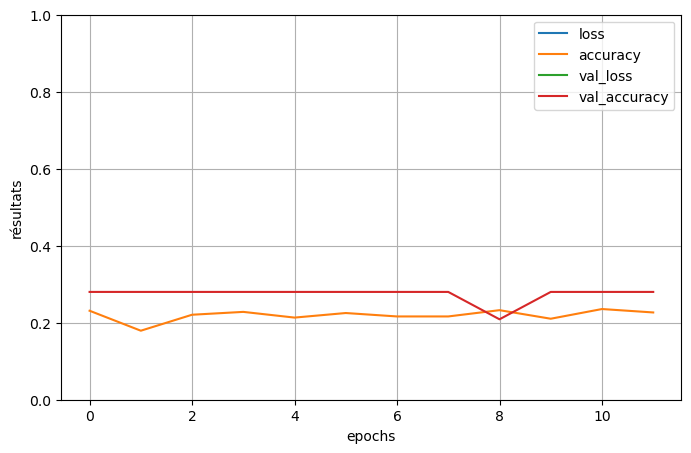

In [224]:
pd.DataFrame(history4.history).plot(figsize = (8,5))
plt.xlabel('epochs')
plt.ylabel('résultats')
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [375]:
model = SVC()

Scaller = StandardScaler()

X = images_features
y = df.label

X = Scaller.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.array([list(x) for x in X_train])


model.fit(X_train,y_train)
y_pred = model.predict(X_test)

score = model.score(X_test,y_test)     
print(f" score = {round(score,2)} ")



 score = 0.9 


In [41]:
t0 = time.time()

pipe = Pipeline([
                ("estimator",LogisticRegression())
                ])
pipe


X = images_features
y = df.label


param_grid = {
              'estimator':[RandomForestClassifier(),
                           AdaBoostClassifier(),
                           GradientBoostingClassifier(),
                           ExtraTreesClassifier(),
                           DecisionTreeClassifier(),
                           SVC(),
                           BaggingClassifier(),
                           KNeighborsClassifier(13),
                           LogisticRegression()
                          ]}


grid = GridSearchCV(pipe,param_grid=param_grid, cv=5,return_train_score=True ,n_jobs=-1, verbose=1)

grid.fit(X,y)

grid_cv = pd.DataFrame(grid.cv_results_)

new_cols = [i for i in grid_cv.columns if 'split' not in i.lower()]

duration1=time.time() - t0
print("temps : ", "%15.2f" % duration1, "secondes")

grid_cv.loc[:,new_cols].sort_values('mean_test_score', ascending=False)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
temps :           244.37 secondes


C:\Users\Dragomir\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
8,0.765163,0.138711,0.003799,0.000749,LogisticRegression(),{'estimator': LogisticRegression()},0.858095,0.050070,1,0.997143,0.000952
5,0.706301,0.124750,0.318831,0.101130,SVC(),{'estimator': SVC()},0.853333,0.064270,2,0.974048,0.004286
7,0.014999,0.006723,0.064622,0.015925,KNeighborsClassifier(n_neighbors=13),{'estimator': KNeighborsClassifier(n_neighbors...,0.844762,0.047198,3,0.885476,0.010085
3,1.131753,0.132993,0.031404,0.005422,ExtraTreesClassifier(),{'estimator': ExtraTreesClassifier()},0.838095,0.078535,4,1.000000,0.000000
2,236.363576,1.285368,0.004798,0.000757,GradientBoostingClassifier(),{'estimator': GradientBoostingClassifier()},0.835238,0.071688,5,1.000000,0.000000
0,2.811436,0.265172,0.034703,0.010418,RandomForestClassifier(),{'estimator': RandomForestClassifier()},0.830476,0.074420,6,1.000000,0.000000
6,8.308123,0.381218,0.021406,0.001864,BaggingClassifier(),{'estimator': BaggingClassifier()},0.780000,0.089514,7,0.995714,0.001615
4,1.559708,0.152878,0.001200,0.000400,DecisionTreeClassifier(),{'estimator': DecisionTreeClassifier()},0.655238,0.073500,8,1.000000,0.000000
1,12.851390,0.459822,0.064434,0.010827,AdaBoostClassifier(),{'estimator': AdaBoostClassifier()},0.467619,0.055810,9,0.511905,0.050882


In [81]:
from tensorflow.keras import layers
import PIL

### data augmentation autre approche

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-3.0633 0.056850355 1.5323602


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


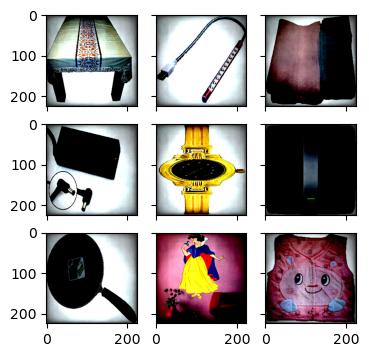

In [128]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# load data
X_train, X_test,y_train, y_test = train_test_split(tab_img,df.label,test_size=0.2 )
# reshape to be [samples][width][height][channels]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit parameters from data
X_mean = X_train.mean(axis=0)
datagen.fit(X_train - X_mean)
# configure batch size and retrieve one batch of images

for X_batch, y_batch in datagen.flow(X_train-X_mean, y_train, batch_size=9, shuffle=False):
    print(X_batch.min(), X_batch.mean(), X_batch.max())
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j], cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break



In [153]:
y_train

array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [203]:
val_.x.shape

(1050, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


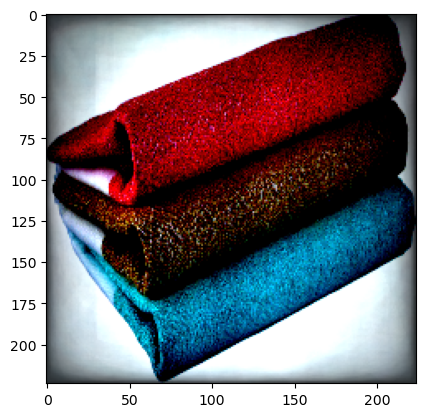

In [195]:
plt.imshow(val_[0][0][1])

In [12]:
def image_prep_fct2(data) :

    img = load_img(data,target_size=(224, 224))
    img = img_to_array(img)
    img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)
    img = np.array(img)
        
    return img

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)


tab_img = np.zeros((1050,224,224,3))
for i in range(len(img_path)):
    
    tab_img[i] = np.array(load_img(img_path[i],target_size=(224, 224,3)))


y = to_categorical(df.label, num_classes=6)
X = tab_img
X_mean = X.mean(axis=0)
datagen.fit(X - X_mean)
data_augment = datagen.flow(X-X_mean, y, shuffle=False)

augmented_data = data_augment.x

C:\Users\Dragomir\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [14]:
tab_img_org = np.zeros((1050,224,224,3))
for i in range(len(img_path)):
    
    tab_img_org[i] = image_prep_fct2(img_path[i])


In [15]:
data_mix = np.concatenate([tab_img_org,augmented_data],axis = 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


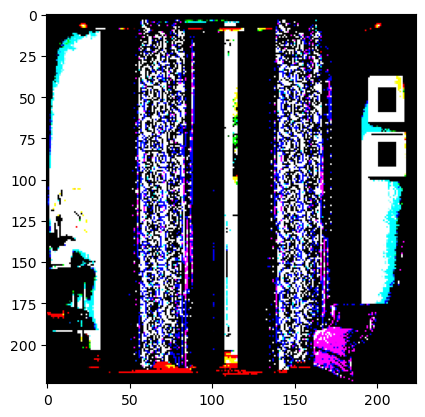

In [16]:
plt.imshow(data_mix[1050])

In [17]:
y1_augmented = df.label
y2 = df.label

y_ = np.concatenate([y1_augmented,y2],axis = 0)

In [18]:
len(y_)

2100

In [19]:
X = data_mix[:1600]
y = y_[:1600]
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(1200, 224, 224, 3)

In [20]:
X_val.shape,y_val.shape

((400, 224, 224, 3), (400,))

In [21]:
X_test = data_mix[1601:2100]
y_test = y_[1601:2100]

In [22]:
y_train_encoded = to_categorical(y_train)

y_test_encoded = to_categorical(y_test)

y_val_encoded = to_categorical(y_val)

In [23]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct()

# Création du callback
model4_save_path = "Models/model4_best_w.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [24]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history4 = model4.fit(X_train, y_train_encoded, epochs=15, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val_encoded), verbose=1)



Epoch 1/15
19/19 [==============================] - ETA: 0s - loss: 0.8042 - accuracy: 0.7583
Epoch 1: val_loss improved from inf to 0.52552, saving model to Models\model4_best_w.h5
19/19 [==============================] - 187s 9s/step - loss: 0.8042 - accuracy: 0.7583 - val_loss: 0.5255 - val_accuracy: 0.8375
Epoch 2/15
19/19 [==============================] - ETA: 0s - loss: 0.3980 - accuracy: 0.8883
Epoch 2: val_loss improved from 0.52552 to 0.45253, saving model to Models\model4_best_w.h5
19/19 [==============================] - 153s 8s/step - loss: 0.3980 - accuracy: 0.8883 - val_loss: 0.4525 - val_accuracy: 0.8675
Epoch 3/15
19/19 [==============================] - ETA: 0s - loss: 0.2887 - accuracy: 0.9175
Epoch 3: val_loss improved from 0.45253 to 0.40739, saving model to Models\model4_best_w.h5
19/19 [==============================] - 159s 9s/step - loss: 0.2887 - accuracy: 0.9175 - val_loss: 0.4074 - val_accuracy: 0.8600
Epoch 4/15
19/19 [==============================] - ETA:

In [27]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(X_train, y_train_encoded, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(X_val, y_val_encoded, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

38/38 [==============================] - 126s 3s/step - loss: 0.0330 - accuracy: 0.9933
Training Accuracy: 0.9933

13/13 [==============================] - 42s 3s/step - loss: 0.3699 - accuracy: 0.8875
Validation Accuracy:  0.8875


In [31]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(X_val, y_val_encoded, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(X_test, y_test_encoded, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8850
Test Accuracy       :  0.8056


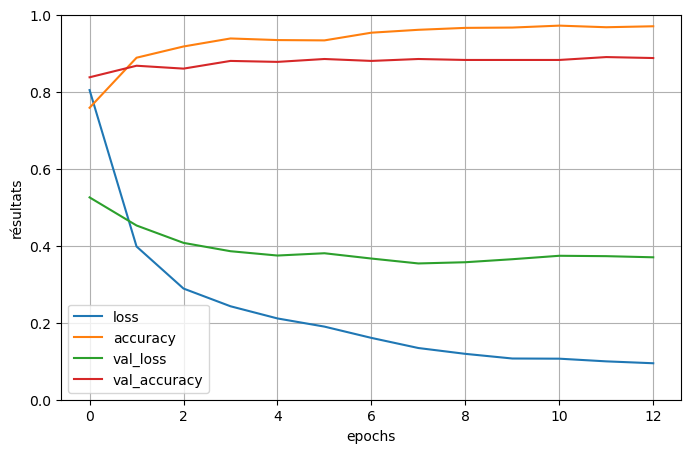

In [32]:
pd.DataFrame(history4.history).plot(figsize = (8,5))
plt.xlabel('epochs')
plt.ylabel('résultats')
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

array([3, 1, 2, 0, 3, 2, 1, 0, 3, 5, 5, 3, 4, 0, 0, 3, 3, 5, 4, 5, 3, 3,
       2, 4, 1, 5, 3, 2, 4, 2, 0, 0, 2, 3, 4, 2, 1, 4, 2, 0, 0, 2, 4, 3,
       4, 4, 3, 3, 4, 4, 5, 3, 5, 4, 3, 3, 0, 5, 1, 5, 3, 4, 2, 4, 3, 3,
       2, 5, 0, 3, 2, 5, 3, 3, 0, 3, 5, 3, 5, 3, 3, 2, 2, 5, 4, 1, 4, 3,
       4, 3, 1, 0, 5, 3, 4, 3, 5, 1, 4, 4, 2, 3, 5, 4, 4, 1, 4, 4, 3, 3,
       0, 2, 5, 1, 5, 5, 5, 4, 3, 3, 4, 2, 3, 3, 4, 3, 4, 5, 0, 5, 1, 2,
       0, 3, 4, 3, 1, 3, 2, 3, 5, 3, 3, 1, 5, 4, 5, 3, 3, 1, 2, 4, 1, 2,
       1, 0, 3, 5, 3, 3, 5, 2, 2, 3, 1, 4, 1, 5, 0, 3, 2, 1, 3, 4, 4, 0,
       1, 3, 4, 2, 1, 1, 0, 2, 0, 4, 1, 3, 4, 3, 2, 5, 4, 3, 2, 5, 2, 1,
       5, 5, 0, 2, 2, 0, 3, 2, 5, 4, 3, 5, 0, 3, 2, 3, 0, 1, 3, 4, 1, 3,
       0, 2, 2, 3, 5, 4, 4, 4, 5, 3, 4, 4, 4, 5, 3, 0, 3, 1, 0, 1, 2, 1,
       1, 5, 2, 5, 4, 0, 3, 1, 5, 1, 3, 1, 0, 0, 3, 2, 3, 3, 4, 2, 5, 5,
       3, 3, 5, 1, 3, 2, 3, 3, 4, 2, 5, 3, 2, 0, 2, 3, 5, 3, 1, 4, 2, 3,
       2, 0, 1, 1, 4, 0, 0, 2, 5, 4, 3, 3, 4, 1, 3,

In [35]:
y_val_num = np.argmax(y_val_encoded, axis=1)
y_val_pred = np.argmax(model4.predict(X_val), axis=1)
print(y_val_num[:10])
print()
print(y_val_pred[:10])

13/13 [==============================] - 44s 3s/step
[3 1 2 0 3 2 1 0 3 5]

[3 1 2 0 3 2 1 3 3 5]


In [36]:
conf_mat = confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

print(classification_report(y_val_num, y_val_pred))

[[36  2  0  9  1  0]
 [ 0 51  2  6  0  2]
 [ 0  2 56  1  1  0]
 [ 4  4  0 94  2  0]
 [ 1  5  0  1 61  0]
 [ 0  0  0  2  1 56]]
              precision    recall  f1-score   support

           0       0.88      0.75      0.81        48
           1       0.80      0.84      0.82        61
           2       0.97      0.93      0.95        60
           3       0.83      0.90      0.87       104
           4       0.92      0.90      0.91        68
           5       0.97      0.95      0.96        59

    accuracy                           0.89       400
   macro avg       0.89      0.88      0.88       400
weighted avg       0.89      0.89      0.89       400



In [38]:
y_test_num = np.argmax(y_test_encoded, axis=1)
y_test_pred = np.argmax(model4.predict(X_test), axis=1)
print(y_test_num)
print()
print(y_test_pred)

16/16 [==============================] - 49s 3s/step
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 2 0 3 0 0 3 3 3 0 2 0 3 4 5 4 2 2 1 1 1 3 3 3 0 0 3 0 0 0 0 0 0 0 0 0 0
 3 3 1 4 0 0 0 0 0 0 0 0 0 4 2 0 0 0 2 0 0 0 0 0 3 3 0 5 3 0 0 0 0 3 3 3 3
 3 3 0 0 0 0 4 0 0 4 0 4 3 0 3 4 0 3 4 0 1 1 1 1 1 1 1 4 1 1 1 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 0 3 3 0 3 3 3 3 3 3 0 3 3 3 3 3 3 0 3 3 3 1 3 0 2 3 1
 1 1 3 4 2 5 4 4 4 4 3 1 1 3 3 3 3 3 3 3 3 5 3 5 5 5 5 5 5 4 4 1 1 5 0 0 0
 0 0 0 0 5 1 1 5 5 5 0 0 0 5 5 5 0 5 1 1 0 1 5 5 1 1 3 2 1 1 2 1 1 1 1 1 1
 1 3 3 3 3 3 3 3 3 3 1 3 3 5 3 5 5 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 0 1 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0
 3 3 3 1 3 0 3 3 3 3 3 3 3 3 1 3 1 3 4 3 0 3 3 0 0 0 0 3 3 5 0 0 3 3 3 3 3
 3 3 3 1 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 4 3
 3 3 3 3 3 3 3 1 4 0 0 3 0 0 0 3 3 0 1 0 4 0 0 0 0 0 3 1 3 3 1 3 0 4 4 3 4
 0 0 3 4 3 4 0 2 4 0 1 1 1 4 3 0 0 3 1 0 2 1 3 

In [39]:
conf_mat = confusion_matrix(y_test_num, y_test_pred)
print(conf_mat)

print(classification_report(y_test_num, y_test_pred))

[[ 75   4   3  21   3   2]
 [  2  45   0  10   0   1]
 [  1   2  46   7   0   2]
 [  6   7  10 158   1   2]
 [  1   3   2   2  20   0]
 [  0   1   1   2   1  58]]
              precision    recall  f1-score   support

           0       0.88      0.69      0.78       108
           1       0.73      0.78      0.75        58
           2       0.74      0.79      0.77        58
           3       0.79      0.86      0.82       184
           4       0.80      0.71      0.75        28
           5       0.89      0.92      0.91        63

    accuracy                           0.81       499
   macro avg       0.81      0.79      0.80       499
weighted avg       0.81      0.81      0.80       499



In [40]:
list_labels = df.category_name.unique()
list_labels
nb_classe = np.arange(0,6)
nb_classe

array([0, 1, 2, 3, 4, 5])

<AxesSubplot:>

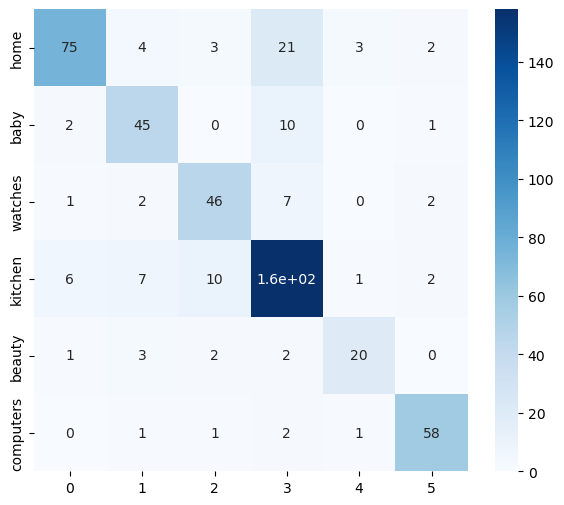

In [41]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in nb_classe])
plt.figure(figsize = (7,6))
sns.heatmap(df_cm, annot=True, cmap="Blues")